# The North Face e-commerce : boosting online sales !

## NLP Project - Unsupervised Learning
This project is for [JEDHA](https://www.jedha.co/) Data Science Full-Stack Bootcamp.

## Project 🚧
The marketing department of NorthFace would like to take advantage of machine learning solutions to boost online sales on the website : https://www.thenorthface.fr/

They have identified two major solutions that could have a huge effect on the conversion rates :

Deploying a recommender system that will allow to suggest additionnal products to users, that are similar to the items they are already interested in. The recommendations could be materialized by a "you might also be interested by these products..." section that would appear on each product page of the website.
Improving the structure of the products catalog thanks to topic extraction. The idea is to use unsupervised methods to challenge the existing categories : is it possible to find new categories of product that would be more suitable for the navigation on the website ?

## Goals 🎯
The project can be cut into three steps :
- Identify groups of products that have similar descriptions.
- Use the groups of similar products to build a simple recommender system algorithm.
- Use topic modeling algorithms to automatically assess the latent topics present in the item descriptions.

## Installing and Importing Packages

In [6]:
!python -m spacy download en_core_web_sm -q

2023-11-16 19:31:32.474411: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-16 19:31:32.474487: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-16 19:31:32.474527: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-16 19:31:34.087048: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 34.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [78]:
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 15.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039166 sha256=a26a87323b36e9a11e09b7f1377578defb22b9f230b3b08d3bca0987018a70fd
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.5
    Uninstalling Cython-3.0.5:
      Successfully uninstalled Cython-3.0.5


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import TruncatedSVD

import hdbscan

import random


In [4]:
nlp = en_core_web_sm.load()

## Importing the Dataset

In [7]:
df = pd.read_csv("sample-data.csv")
df.head(10)

id                                        description
0   1  Active classic boxers - There's a reason why o...
1   2  Active sport boxer briefs - Skinning up Glory ...
2   3  Active sport briefs - These superbreathable no...
3   4  Alpine guide pants - Skin in, climb ice, switc...
4   5  Alpine wind jkt - On high ridges, steep ice an...
5   6  Ascensionist jkt - Our most technical soft she...
6   7  Atom - A multitasker's cloud nine, the Atom pl...
7   8  Print banded betina btm - Our fullest coverage...
8   9  Baby micro d-luxe cardigan - Micro D-Luxe is a...
9  10  Baby sun bucket hat - This hat goes on when th...

Above we can see that some words were not acutally spelled properly but used some abbreviations instead. ("btm" for bottom, "jkt" for jacket).
This is one to thing to keep in mind and fix if needed in order to standardize word or frequency counts

In [8]:
print("Number of products is:",df.shape[0])

Number of products is: 500


Let's check the product descriptions of first 5 products from the dataset to get an idea:

In [11]:
df['description'][:3].tolist()

['Active classic boxers - There\'s a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"Exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"Inseam (size M) is 4 1/2"""</li></ul><br><br><b>Fabric: </b>3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>99 g (3.5 oz)<br><

Another thing we could notice from the product descriptions is that the current format of the text contain html tags which we should remove before training the model

## Text Preprocessing

### Steps:

- remove HTML tags like ("</"li>",<"/ul">,<"br">,,<"b">)
- standardize the spelling of items like bottom or jacket
- remove the stop words, including custom common words
- lemmatize the tokens
- remove punctuation and adjust spaces

#### HTML tags  : First approach

In [17]:
def clean_html(text): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', text)
    #adjust number of spaces:
    cleantext = re.sub(r'\s\s+', ' ', cleantext)
    return cleantext

#let's try out the function:
clean_html(df['description'][0])

'Active classic boxers - There\'s a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program. Details: "Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry" "Exposed, brushed elastic waistband for comfort" 5-panel construction with traditional boxer back "Inseam (size M) is 4 1/2""" Fabric: 3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program Weight: 99 g (3.5 oz) Made in Mexico.'

#### Second approach: Beautiful Soup

In [18]:
def remove_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    clean_text = soup.get_text(separator=' ')
    clean_text = re.sub(r'\s\s+', ' ', clean_text)
    return clean_text

#let's try out the function:
remove_html(df['description'][0])

'Active classic boxers - There\'s a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program. Details: "Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry" "Exposed, brushed elastic waistband for comfort" 5-panel construction with traditional boxer back "Inseam (size M) is 4 1/2""" Fabric: 3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program Weight: 99 g (3.5 oz) Made in Mexico.'

Both method seems equally fine.
Let's pick one and create a new column without html tags.

In [20]:
df['description_2'] = df['description'].apply(lambda x: remove_html(x))

### Standardize Spelling
Let's first check if those words are in the spellled different ways during the text

In [21]:
spellings = ['jkt','jacket', 't-shirt', 'tshirt', 'btm', 'bottom', 'ctn', 'cotton']

all_desc = " ".join(df['description_2'].tolist())
for word in spellings:
  if word in all_desc:
    print("yes")

yes
yes
yes
yes
yes
yes
yes
yes


In [22]:
def standardize_items(text): #function to clean the word of any html-tags
    text = re.sub('jkt', 'jacket', text)
    text = re.sub('t-shirt', 'tshirt', text)
    text = re.sub('btm', 'bottom', text)
    text = re.sub('ctn', 'cotton', text)
    return text

df['description_2'] = df['description_2'].apply(lambda x: standardize_items(x))

#### Lemmatization & Removal of Stopwords and Common words

- I decided to apply lemmatization before removing the punctuation and numerical characters, this way ngrams like 'There's' won't be converted to "theres" or "there s" which can misguide the lemmatization.
- Also there are common words like g, oz and even common phrases like "Recyclable through the Common Threads Recycling Program" that serves little in differentiating products so I will remove those as well.

In [23]:
print("Number of descriptions that contains the phrase Recyclable through the Common Threads Recycling Program is "
      , sum(["Recyclable through the Common Threads Recycling Program" in text for text in df['description']]),
     "out of 500")


Number of descriptions that contains the phrase Recyclable through the Common Threads Recycling Program is  352 out of 500


In [79]:
custom_stop_words = ['oz',
                     'g',
                     'weight',
                     'fabric',
                     'details',
                     #'program',
                     #'recyclable',
                     #'through',
                     #'common',
                     #'threads',
                     #'recycling'
                     ]
STOP_WORDS = list(STOP_WORDS) + custom_stop_words

In [26]:
def lemmatize(text):
    doc = nlp(text)
    lemma = [token.lemma_ for token in doc if token.text.lower() not in STOP_WORDS]
    text = " ".join(lemma)
    return text

#test the function:
lemmatize(df['description_2'][0])


'active classic boxer - reason boxer cult favorite - cool , especially sticky situation . quick - dry , lightweight underwear take minimal space travel pack . expose , brush waistband offer - - skin softness , - panel construction traditional boxer classic fit , functional fly . 3.7 - 100 % recycle polyester moisture - wicke performance . Inseam ( size M ) 4 1/2 " . . : " Silky Capilene 1 ultralight , breathable quick - - dry " " expose , brush elastic waistband comfort " 5 - panel construction traditional boxer " Inseam ( size M ) 4 1/2 " " " : 3.7 - 100 % - recycle polyester Gladiodor natural odor control garment . : 99 ( 3.5 ) Mexico .'

In [27]:
df['cleaned_docs'] = df['description_2'].apply(lambda x: lemmatize(x))

#### Now we can remove punctuation, numbers and extra spaces

In [28]:
def remove_punct_num(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s\s+', ' ', text)
    return text

remove_punct_num(df['cleaned_docs'][0])

'active classic boxer reason boxer cult favorite cool especially sticky situation quick dry lightweight underwear take minimal space travel pack expose brush waistband offer skin softness panel construction traditional boxer classic fit functional fly recycle polyester moisture wicke performance Inseam size M Silky Capilene ultralight breathable quick dry expose brush elastic waistband comfort panel construction traditional boxer Inseam size M recycle polyester Gladiodor natural odor control garment Mexico '

In [29]:
df['cleaned_docs'] = df['cleaned_docs'].apply(lambda x: remove_punct_num(x))

### Vectorization

In [31]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['cleaned_docs'])

In [32]:
dense = X.toarray()
tfidf = pd.DataFrame(dense, columns=[x for x in vectorizer.get_feature_names_out()])
print(tfidf.shape)
tfidf.head()

(500, 3587)


abandon  ability  able  abrasion  abrasive  abroad  absolute  absorb  \
0      0.0      0.0   0.0       0.0       0.0     0.0       0.0     0.0   
1      0.0      0.0   0.0       0.0       0.0     0.0       0.0     0.0   
2      0.0      0.0   0.0       0.0       0.0     0.0       0.0     0.0   
3      0.0      0.0   0.0       0.0       0.0     0.0       0.0     0.0   
4      0.0      0.0   0.0       0.0       0.0     0.0       0.0     0.0   

   absorption  abstract  ...  zest  zinger  zip  zipped    zipper  zippered  \
0         0.0       0.0  ...   0.0     0.0  0.0     0.0  0.000000  0.000000   
1         0.0       0.0  ...   0.0     0.0  0.0     0.0  0.000000  0.000000   
2         0.0       0.0  ...   0.0     0.0  0.0     0.0  0.000000  0.000000   
3         0.0       0.0  ...   0.0     0.0  0.0     0.0  0.053478  0.271961   
4         0.0       0.0  ...   0.0     0.0  0.0     0.0  0.118591  0.040206   

   zippers  zipping  zips  zone  
0      0.0      0.0   0.0   0.0  
1      0.0      0.0   0.0   0.0  
2      0.0      0.0   0.0   0.0  
3      0.0      0.0   0.0   0.0  
4      0.0      0.0   0.0   0.0  

[5 rows x 3587 columns]

## PART 1 : Clustering

### DBSCAN

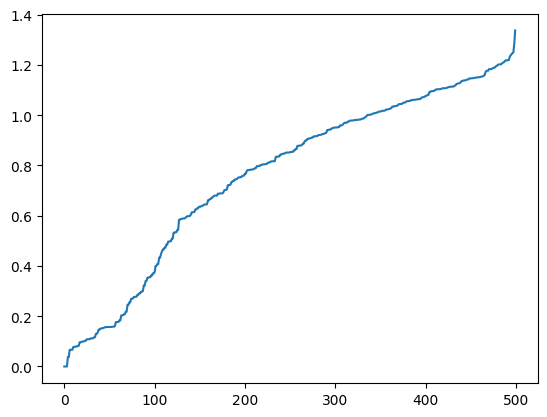

In [33]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(dense)
distances, indices = neighbors_fit.kneighbors(dense)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [56]:
db = DBSCAN(eps=0.6, min_samples=5, metric="cosine", algorithm="brute")
db.fit(X)
set(db.labels_)

{-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21}

In [57]:
predictions = db.fit_predict(X).tolist()
pred_to_label = {}
for label,prediction in enumerate(list(set(predictions))):
    pred_to_label[prediction] = "Cluster_"+ str(label)
pred_to_label

{0: 'Cluster_0',
 1: 'Cluster_1',
 2: 'Cluster_2',
 3: 'Cluster_3',
 4: 'Cluster_4',
 5: 'Cluster_5',
 6: 'Cluster_6',
 7: 'Cluster_7',
 8: 'Cluster_8',
 9: 'Cluster_9',
 10: 'Cluster_10',
 11: 'Cluster_11',
 12: 'Cluster_12',
 13: 'Cluster_13',
 14: 'Cluster_14',
 15: 'Cluster_15',
 16: 'Cluster_16',
 17: 'Cluster_17',
 18: 'Cluster_18',
 19: 'Cluster_19',
 20: 'Cluster_20',
 21: 'Cluster_21',
 -1: 'Cluster_22'}

In [58]:
df['cluster'] = [pred_to_label[x] for x in predictions]
df.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                                  description_nohtml  \
0  Active classic boxers - There's a reason why o...   
1  Active sport boxer briefs - Skinning up Glory ...   
2  Active sport briefs - These superbreathable no...   
3  Alpine guide pants - Skin in, climb ice, switc...   
4  Alpine wind jkt - On high ridges, steep ice an...   

                                description_nohtml_2  \
0  Active classic boxers - There's a reason why o...   
1  Active sport boxer briefs - Skinning up Glory ...   
2  Active sport briefs - These superbreathable no...   
3  Alpine guide pants - Skin in, climb ice, switc...   
4  Alpine wind jkt - On high ridges, steep ice an...   

                                       description_2  \
0  Active classic boxers - There's a reason why o...   
1  Active sport boxer briefs - Skinning up Glory ...   
2  Active sport briefs - These superbreathable no...   
3  Alpine guide pants - Skin in, climb ice, switc...   
4  Alpine wind jacket - On high ridges, steep ice...   

                                        cleaned_docs     cluster  
0  active classic boxer reason boxer cult favorit...  Cluster_22  
1  active sport boxer brief skin glory require mo...  Cluster_22  
2  active sport brief superbreathable fly brief m...  Cluster_22  
3  alpine guide pant skin climb ice switch rock t...   Cluster_0  
4  alpine wind jacket high ridge steep ice alpine...   Cluster_1

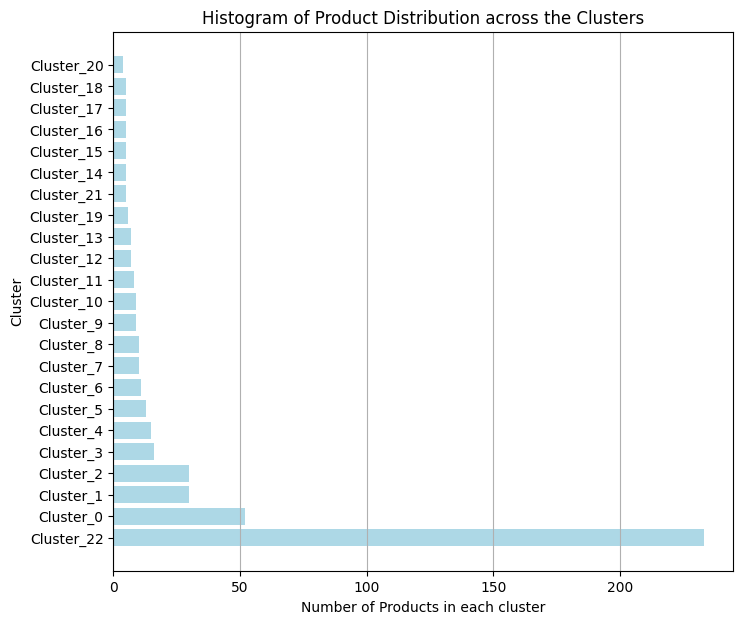

In [67]:
plt.figure(figsize=(8, 7))
plt.barh(df["cluster"].unique(), df["cluster"].value_counts(), color= 'lightblue')
# Adding labels and title
plt.xlabel('Number of Products in each cluster')
plt.ylabel('Cluster')
plt.title('Histogram of Product Distribution across the Clusters')

plt.grid(axis='x')

plt.show()

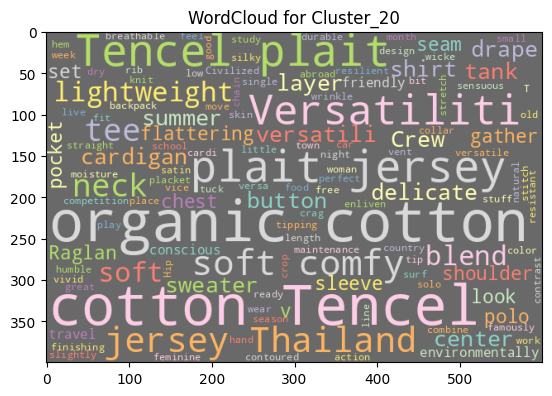

3 examples from Cluster_20 

Versatiliti polo - Civilized, but ready for action, the Versatiliti Polo's rib-knit collar and wrinkle-resistant 62% organic cotton/38% Tencel plaited jersey still looks great even after a week stuffed in a backpack. Raglan sleeves and contrast tipping on the set-in chest pocket and the 3-button placket give it an old-school feel; the straight hem with side vents looks good tucked, or not.<br><br><b>Details:</b><ul> <li>"Environmentally conscious, travel-friendly lightweight organic cotton and Tencel is soft and comfy"</li> <li>Single set-in chest pocket with tipping</li> <li>Raglan sleeves</li></ul><br><br><b>Fabric: </b>5.5-oz 62% organic cotton/38% Tencel plaited jersey. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>(225 g 7.8 oz)<br><br>Made in Thailand.

 Versatiliti tank - Vivid colors and delicate details enliven this season's crop of Versatiliti Tanks. Made of a lightweight blend of 62% organic cotton/38% Tencel that 

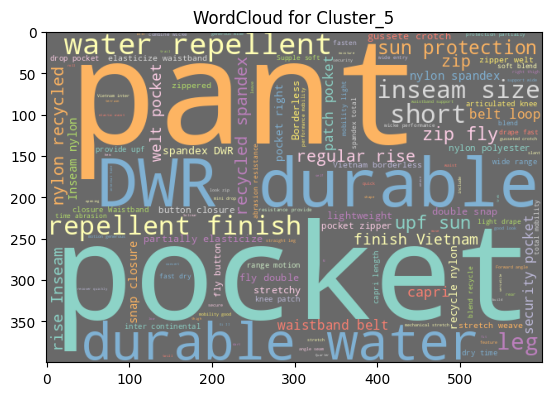

3 examples from Cluster_5 

Borderless capris - Unfazed by gloppy spindrift, Borderless Capris relish trails that more resemble creeks. The versatile Borderless Capris are made from a moisture-wicking blend of stretchy nylon/spandex fabric with built-in 40-UPF sun protection. Articulated knee patches, front and back, provide unrestricted movement. A master stasher, the capris have two front pockets, two back pockets and a zippered security pocket on the right thigh. Zip fly and double-snap closure at the waist. Drawcords at leg cuffs prevent slippage; inseam (size 8) is 23". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Stretchy recycled nylon fabric combines wicking performance, mobility and good looks; zip fly with double-snap closure"</li> <li>Waistband with belt loops</li> <li>2 front patch pockets; 2 welted back pockets; zippered security patch pocket on right leg</li> <li>Articulated knee patches</li> <li>Drawcords at leg cuffs</li> <li>

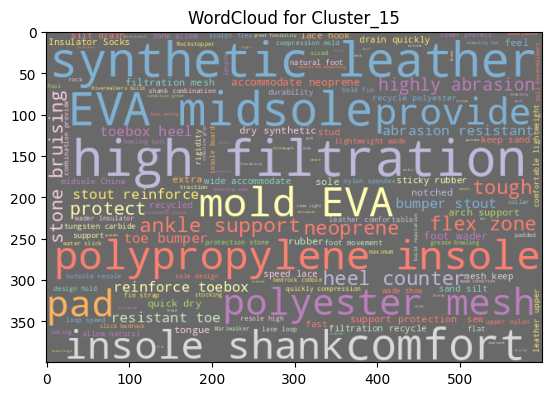

3 examples from Cluster_15 

Riverwalker - sticky - High water. Slick bedrock. Cobbles like greased bowling balls. Our Riverwalkers built their reputation in the most demanding wading conditions, with great flexibility, fast drying times and light weight. Notched flex zones allow for natural foot movement; a polypropylene insole/shank provides stability. But don't let the comfort fool you: These are tough boots for serious wading. Details: synthetic leather and high-filtration polyester mesh (100% recycled) uppers for maximum support, protected lacing, molded EVA midsole; our Rockstopper insole/shank stabilizes grip and protects against stone-bruising. Extra comfort thanks to the padded insole and ankle support; extra durability from the highly abrasion-resistant toe bumper with stout, reinforced toebox and heel counter. In three resoleable choices: felt (sewn on), tungsten-carbide studded and sticky rubber. Sized to accommodate neoprene stocking-foot waders.<br><br><b>Details:</b><ul>

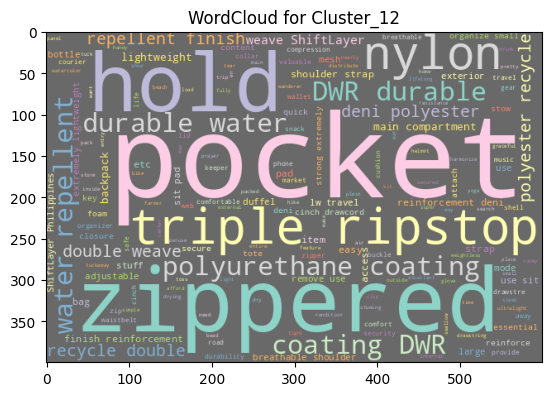

3 examples from Cluster_12 

Lw travel courier - This graceful rendition of the courier bag is sleek and nearly weightless. It has a zippered closure with adjustable drawstring, and a zippered security pocket for your bike light or prayer beads. Its breathable, adjustable shoulder strap is comfortable and quick-drying. When not in use, the bag stuffs into its own pocket for easy stowing. Made with strong yet extremely lightweight 50-denier triple-ripstop nylon with a polyurethane coating and a DWR (durable water repellent) finish. Bottom reinforcement is 150-denier polyester (47% recycled) double-weave ShiftLayer.<br><br><b>Details:</b><ul> <li>Main compartment accessed through top by zippered closure with adjustable drawstring</li> <li>Zippered security pocket and key clip</li> <li>Bag stuffs into its own pocket when not in use</li> <li>"Breathable shoulder strap is ultralight, quick-drying and adjustable"</li> <li>Extremely lightweight triple-ripstop fabric affords excellent tear res

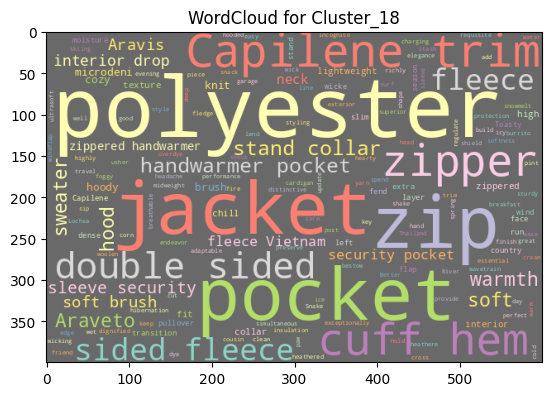

3 examples from Cluster_18 

Araveto 1/4 zip jkt - A slim fit and zip-through stand-up collar make the Araveto 1/4-Zip Jacket the perfect midweight layering piece or stand-alone fleece sweater for a spring chill. Like its cousins the Araveto Jacket and Hoody, this ultrasoft pullover is made with 8-oz microdenier 100% polyester double-sided fleece, and trimmed out with Capilene 3 fabric at the cuffs and hem for simultaneous wicking and insulation. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>1/4-zip pullover in soft brushed polyester fleece</li> <li>Zip-through stand-up collar</li> <li>Capilene 3 trim at cuffs and hem</li></ul><br><br><b>Fabric: </b>8-oz microdenier 100% polyester double-sided fleece. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>309 g (10.9 oz)<br><br>Made in Vietnam.

 Better sweater jkt - The Better Sweater Jacket has all the lightweight, moisture-wicking warmth of a high-performance fleece bu

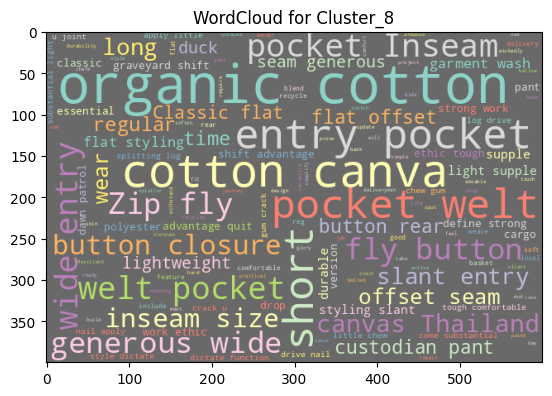

3 examples from Cluster_8 

Duck pants - long - Essential wear for splitting logs, driving nails or applying a little more chewing gum to the crack in the U-joint. Our classic do-alls come in a substantial but light and supple 8-oz organic cotton canvas. With style that is dictated by function, they have a flat front, slant side-entry front pockets and welted, button-through rear pockets. Garment-washed. Inseam (size 32) is 32" for the regular version; 30" for the short; 34" for the long. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>Supple organic cotton</li> <li>Classic flat-front styling</li> <li>"Slant side-entry front pockets; welted, button-through rear pockets"</li> <li>"Inseam is 34"""</li></ul><br><br><b>Fabric: </b>8-oz 100% organic cotton canvas. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>532 g (18.8 oz)<br><br>Made in Thailand.

 All-wear shorts - Time to simplify? Our All-Wear shorts prove that on

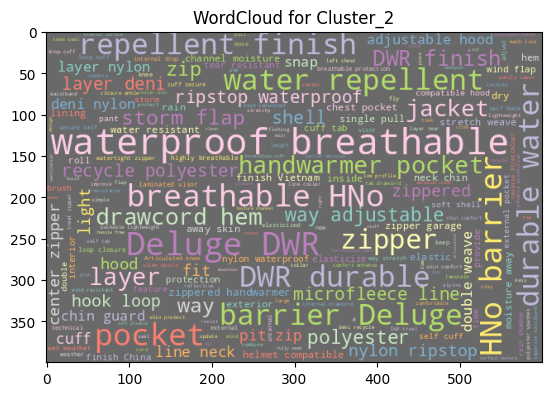

3 examples from Cluster_2 

All-time shell - No need to use that morning Times as an umbrella. The All-Times' handsome matte-finish, 100% recycled polyester shell provides tasteful sports-coat-length coverage for the vicissitudes of weather in the city and country. A hardy 2.5-layer, 4.2-oz polyester ripstop with an H2No waterproof/breathable barrier and a Deluge DWR (durable water repellent) finish scoffs at cloudbursts; a 100% polyester (60% recycled) brushed fleece collar lining and chin guard keep you feeling well-kept, and the zip-off hood gives you options and keeps you dry. The 2-way zip allows for flexibility when sitting. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>2.5-layer 100% all-recycled polyester shell with a matte ripstop surface and a waterproof/breathable H2No barrier</li> <li>"Snap-off detachable storm hood, protective microfleece-lined collar and chin guard"</li> <li>2-way zip</li> <li>Laser-cut zippered handwarmer pockets

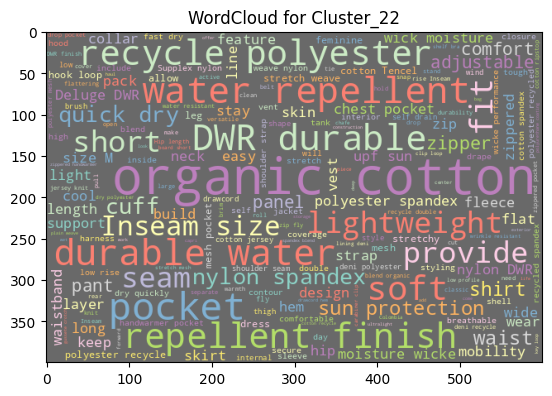

3 examples from Cluster_22 

Sun shelter shirt - Chic and sensible, the Sun Shelter saves your skin for something more deserving than a tan. Fusing sun protection with feminine styling, the hip length Sun Shelter has delicate yoke detailing, a mandarin collar and slightly belled sleeves that stay put when rolled up. Made from a fine, yarn-dyed 57% all-recycled polyester/43% nylon fabric blend (with 40-UPF sun protection) that launders easily and dries overnight. Soft, lightweight and wrinkle resistant for carry-on packability. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Quick-drying recycled polyester/nylon blend is exceptionally soft and light, with 40-UPF rating for sun protection"</li> <li>"Mandarin collar, full front placket"</li> <li>Flattering yoke detail adds feminine appeal</li></ul><br><br><b>Fabric: </b>2.5-oz 57% all-recycled polyester/43% nylon with 40-UPF sun protection. Recyclable through the Common Threads Recycling Program<br

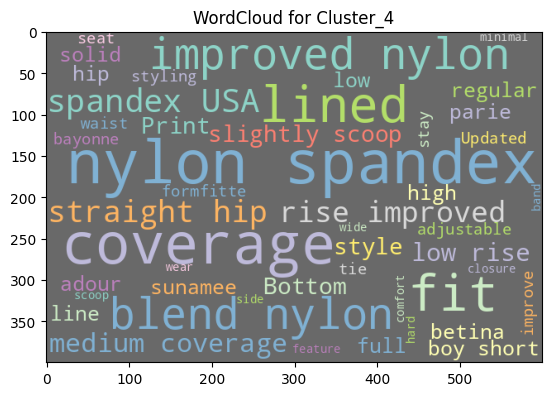

3 examples from Cluster_4 

Print paries btm - Styled like a boy short, our Paries Bottoms fit low and straight across the hips, with medium coverage in front and full coverage in back. Lined front. Made from our improved fabric blend of 82% nylon/18% spandex.<br><br><b>Details:</b><ul> <li>Boy-short style</li> <li>Lined front</li> <li>Fits low and straight across hips</li> <li>Updated waist styling</li> <li>Medium coverage in front; full back coverage</li> <li>Improved fabric</li></ul><br><br><b>Fabric: </b>5.6-oz 82% nylon/18% spandex<br><br><b>Weight: </b>(54 g 1.9 oz)<br><br>Made in USA.

 Print adour btm - Adours have a slightly scooped, low-rise front (lined) and medium coverage in back. Our improved fabric blend is made of 82% nylon/18% spandex.<br><br><b>Details:</b><ul> <li>Medium coverage</li> <li>Lined front</li> <li>Slightly scooping front</li> <li>Low rise</li> <li>Improved fabric</li></ul><br><br><b>Fabric: </b>5.6-oz 82% nylon/18% spandex<br><br><b>Weight: </b>(43 g 1.5 

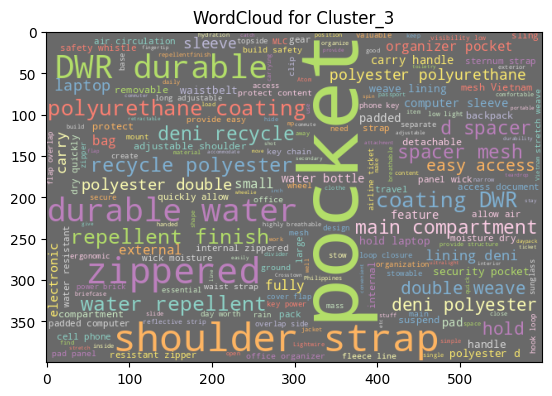

3 examples from Cluster_3 

Atom - A multitasker's cloud nine, the Atom plays the part of courier bag, daypack and carry-on. Its teardrop shape provides the support of a daypack by positioning the load behind your shoulder, and the single-strap design makes getting to the goods simple - just spin it around front. The large zippered main pocket has internal zippered mesh and stretch-woven pockets. A convenient zippered pocket on the shoulder strap is lined to protect valuables. Breathable, moisture-moving 3-D spacer mesh pads the shoulder strap and back panel. Made from 150-denier double-weave all-recycled polyester with a polyurethane coating and DWR (durable water repellent) finish.<br><br><b>Details:</b><ul> <li>Atom spins around from back to chest for easy access</li> <li>Main zippered pocket has internal zippered mesh and stretch-woven organizer pockets</li> <li>Small zippered pocket for essentials</li> <li>"Zippered pocket on shoulder strap is lined to protect cell phone, sunglass

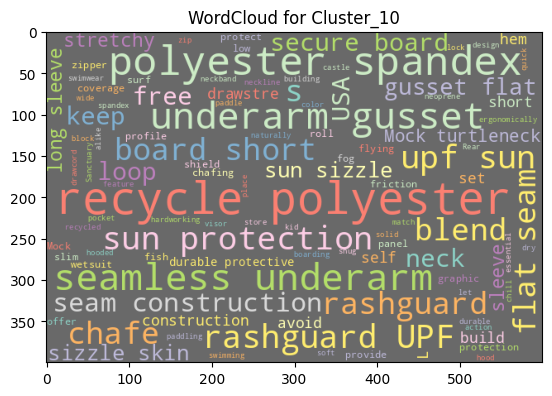

3 examples from Cluster_10 

L/s hooded rashguard - The 30-UPF fabric of our Long-Sleeved Rashguard keeps the sun from sizzling your skin. Made from a durable and protective blend of 84% all-recycled polyester/16% spandex. With seamless underarm gussets and chafe-free construction. The drawstring loop at front secures to board shorts.<br><br><b>Details:</b><ul> <li>All-recycled polyester rashguard has 30-UPF sun protection</li> <li>Sun-blocking 3-panel hood with built-in neoprene visor snugs with locking drawcord</li> <li>Rear zip-pocket stores surf/paddle essentials</li> <li>Seamless underarm gussets and flat-seam construction avoids chafe</li> <li>Self-loop at front hem secures to board shorts</li></ul><br><br><b>Fabric: </b>5.8-oz 84% all-recycled polyester/16% spandex<br><br><b>Weight: </b>(239 g 8.3 oz)<br><br>Made in USA.

 Rashguard - Sanctuary from sun and chill alike: This hardworking top is made of a stretchy blend of quick-drying, 5.8-oz 84% polyester (100% recycled)/16% spa

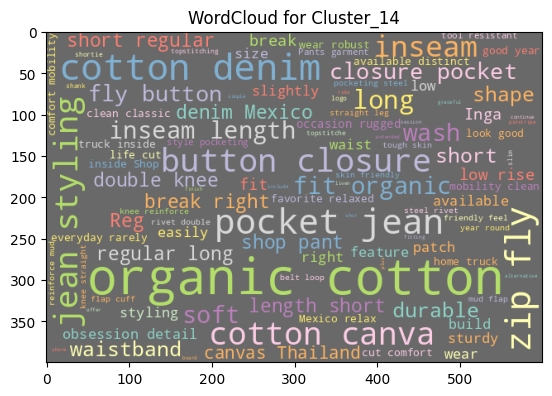

3 examples from Cluster_14 

Shop pants - short - More at home under the truck than inside it, our Shop Pants are made from garment-washed 10-oz 100% organic cotton canvas that's tool-resistant yet breaks in easily. They have a shaped waist, jeans-style pocketing, steel rivets, double-fabric knees and reinforced "mud flaps" above the cuffs. Inseams (size 32): regular is 32";  short is 30" and long 34". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Made from 10-oz year-round weight organic cotton canvas for a tough, yet skin-friendly feel"</li> <li>Waistband slightly lower in front for fit and mobility</li> <li>Zip fly with button closure</li> <li>5-pocket jeans styling</li> <li>Patch pockets on back</li> <li>Double-fabric knees; straight legs</li> <li>"Inseam length is 30"""</li></ul><br><br><b>Fabric: </b>10-oz 100% organic cotton canvas. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>538 g (19 oz)<br><br>Made i

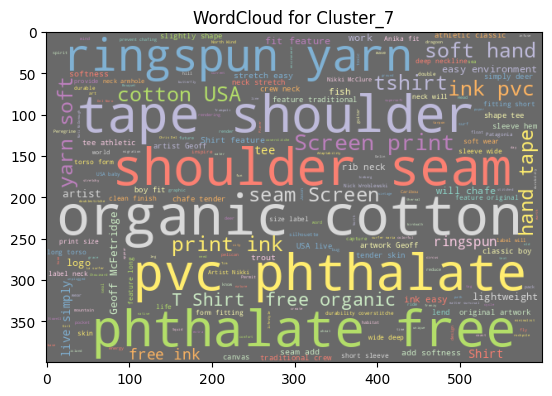

3 examples from Cluster_7 

Permit silhouette t-shirt - The Permit's scythe-shaped dorsal fin propels the saltwater lover across the flats of the Permit Silhouette T-Shirt. Printed on organic cotton (100%) fabric with inks that are PVC- and phthalate-free, the tee has ringspun yarns for softness. Taped shoulder seams lend a durable, clean finish. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>Ringspun yarns for a softer hand</li> <li>Taped shoulder seams</li> <li>Screen-print inks are PVC- and phthalate-free</li></ul><br><br><b>Fabric: </b>5.4-oz 100% organic cotton. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>(199 g 6.9 oz)<br><br>Made in USA.

 City by the sea t-shirt - Illustrating the renaissance of sea-inspired, community living, artist Geoff McFetridge's work adorns the City-By-The-Sea T-Shirt. Lightweight, 100% organic cotton fabric is ringspun for softness. Taped shoulder seams prevent chafing. PVC- and 

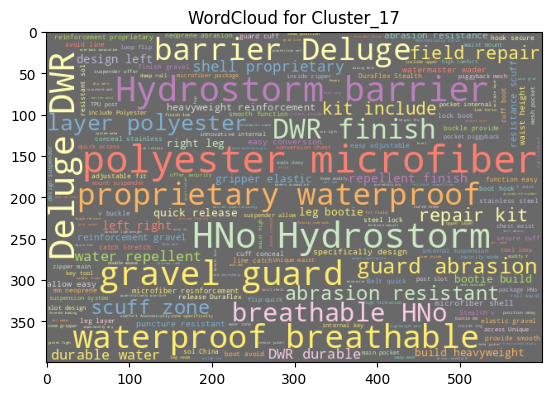

3 examples from Cluster_17 

Watermaster waders - short - Blackberries, barbwire, basalt...the fact is, we ask a lot of our waders - most importantly, that they keep us dry through all sorts of abuse. The new version of our Watermaster Waders accomplishes this on a number of fronts: First, our proprietary waterproof/breathable polyester microfiber fabric package with H2No Hydrostorm barrier is quantitatively more puncture resistant than the competition. Then, because wet is wet, whether it comes from inside or out, we use lighter, more breathable fabric up top and a tougher version below. Finally, and not to be overlooked, our innovative internal suspension system makes it easier than ever to, uh...relieve yourself without taking off jacket or vest. Something to consider in a driving rainstorm. It all adds up to an incredibly dry, durable and lightweight pair of waders. In other words, Watermasters. Field repair kit included.<br><br><b>Details:</b><ul> <li>Polyester microfiber shell wi

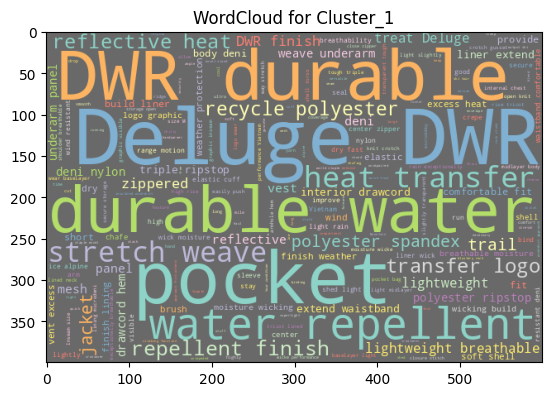

3 examples from Cluster_1 

Nine trails jkt - Somewhere between the Bridger Ridge Run (for normal trail-runners) and the Barkley Marathons (for the insane), we all find our stride. This jacket is made from lightweight, wind-resistant 15-denier 100% nylon that's treated with a Deluge DWR (durable water repellent) finish to shed light rain. Its exceptionally breathable stretch-woven back and underarm panels (91% all-recycled polyester/9% spandex) vent excess heat. The high-rise tricot-lined neck, revised wrists (now with improved elastic-style cuffs that are easily pushed up) and drawcord at the hem seal out chilly weather. The jacket stashes into its own internal chest pocket. Reflective heat-transfer logos (front and back) keep you visible.<br><br><b>Details:</b><ul> <li>"Light, slightly transparent, tough, triple-ripstop nylon soft shell on torso, arms and shoulders, and breathable recycled polyester stretch-woven fabric on back, and underarms; Deluge DWR (durable water repellent) fin

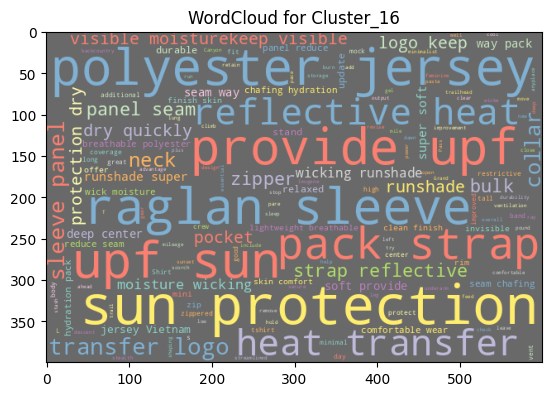

3 examples from Cluster_16 

Runshade t-shirt - Out in the backcountry or anyplace that moves you, our comfortable-wearing Runshade T-Shirt keeps pace. Its lightweight, breathable 100% polyester jersey (updated for better durability) wicks moisture, provides 30-UPF sun protection, and dries quickly. The collar fit is now more relaxed with less bulk, but it still protects your neck from the sun, and the updated raglan sleeves with side panels reduce seam chafing from your hydration pack straps. A reflective heat-transfer logo keeps you visible. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Moisture-wicking, Runshade fabric throughout is super soft and provides 30-UPF sun protection"</li> <li>Relaxed crew collar provides good sun coverage without being restrictive</li> <li>Raglan sleeves and side panels keep seams out of the way of pack straps</li> <li>Reflective heat-transfer logo</li></ul><br><br><b>Fabric: </b>4.3-oz 100% polyester jersey. Re

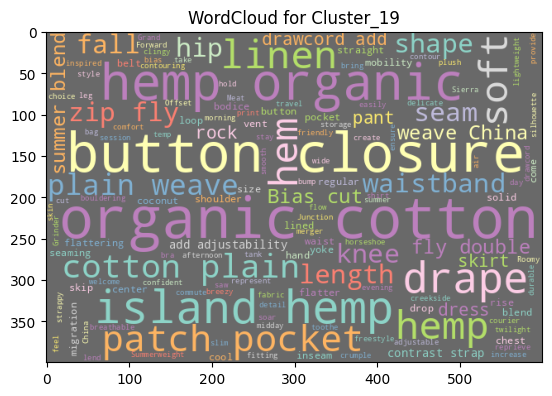

3 examples from Cluster_19 

Island hemp skirt - The Island Hemp Skirt brings freestyle comfort to any creekside rock-skipping session. The skirt's summer-weight hemp/organic cotton (55%/45%) fabric blend has a soft, linen-like drape. Cut on the bias, it has a zip fly with double-button closure and a shaped waistband with adjustable drawcord. Two back patch pockets with button closures hold skipping rocks. Falls below the knee with a waist-to-hem length of 30". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>Hemp is soft with a linen-like drape</li> <li>Zip fly with double button closure</li> <li>Shaped waistband; drawcord for added adjustability</li> <li>Bias-cut for drape</li> <li>2 back patch pockets with button closure</li> <li>Falls below the knee</li> <li>"Waist-to-hem length 30"""</li></ul><br><br><b>Fabric: </b>4-oz 55% hemp/45% organic cotton plain weave. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>(204 

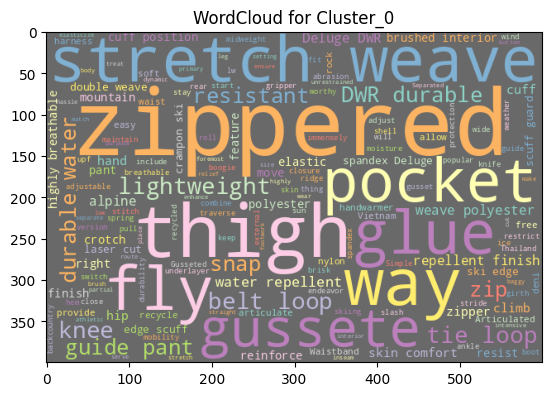

3 examples from Cluster_0 

Alpine guide pants - Skin in, climb ice, switch to rock, traverse a knife-edge ridge and boogie back down - these durable, weather-resistant and breathable soft-shell pants keep stride on every mountain endeavor. The midweight stretch-woven polyester won't restrict your moves, and the brushed interior maintains next-to-skin comfort. A 2-way zippered fly keeps things easy with a harness on, and the gusseted, zippered cuffs have 2-position snaps and tie-down loops. With water-resistant zippered pockets: two front, two thigh, one back hip. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>Durable stretch-woven polyester is water- and wind-resistant and highly breathable</li> <li>Brushed interior for next-to-skin comfort</li> <li>Waistband has elastic on back and belt loops; zippered fly</li> <li>"External pockets: two front slash, two glued-on thigh; all with DWR (durable water repellent) treated zippers"</li> <li>"Gusseted

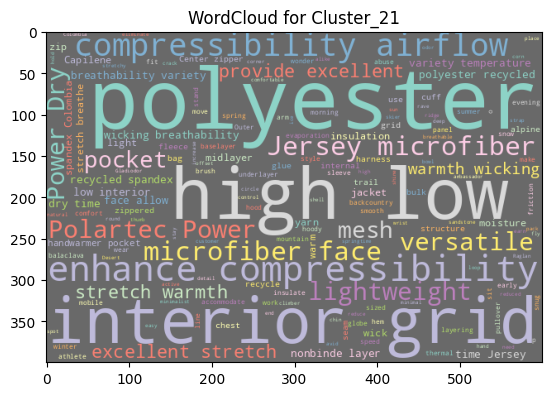

3 examples from Cluster_21 

R1 p/o - Desert sandstone, corn snow, iced-up corners: springtime! Whether the snow flies or the sun shines, our versatile R1 Pullover- with its high/low grid polyester interior - stretches, breathes, moves moisture, and insulates. Sized to accommodate light underlayers, it works as a stand-alone top or as a light midlayer. To reduce bulk, the brushed-mesh internal chest pocket bag is glued-in to eliminate seams. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Recycled and recyclable polyester R1 fabric provides excellent stretch, warmth, wicking and breathability in a variety of temperatures, whether worn as lightweight insulation or a thermal baselayer"</li> <li>Lightweight yarns wick moisture</li> <li>Outer microfiber yarns speed evaporation</li> <li>Interior grid enhances compressibility and airflow</li> <li>"Jersey microfiber face for low-friction, nonbinding layering"</li> <li>"Zippered, brushed-polyester mesh 

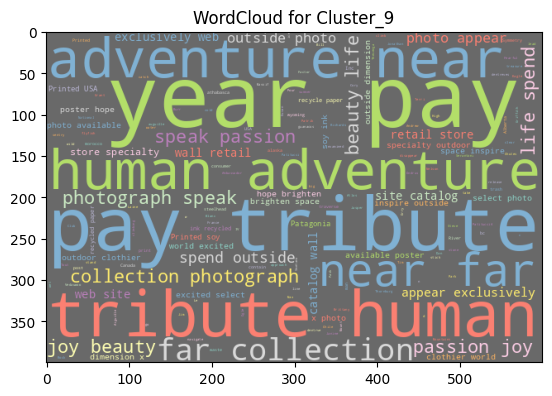

3 examples from Cluster_9 

Flyfishing the athabasca poster - Patrik Ondrus wets his line in the Athabasca River. Jasper National Park, Alberta, Canada. For 30 years we've paid tribute to human adventures both near and far with a collection of photographs that speak to the passion, joy and beauty of lives spent outside. These photos have appeared exclusively on our Web site, in our catalog and on the walls of our retail stores and specialty outdoor clothiers around the world. And now we are excited to make select photos available to you as posters. We hope they brighten up your space and inspire you to get outside.<br><br><b>Details:</b><ul> <li>"Dimensions: 36"" x 24"""</li> <li>Photo by Dusan Smetana</li></ul><br><br><b>Fabric: </b>Printed on recycled paper with soy inks.<br><br>Printed in USA.

 Wyoming climbing poster - Max Factor, 5.11c. Vedauwoo, Wyoming. For 30 years we've paid tribute to human adventures both near and far with a collection of photographs that speak to the passi

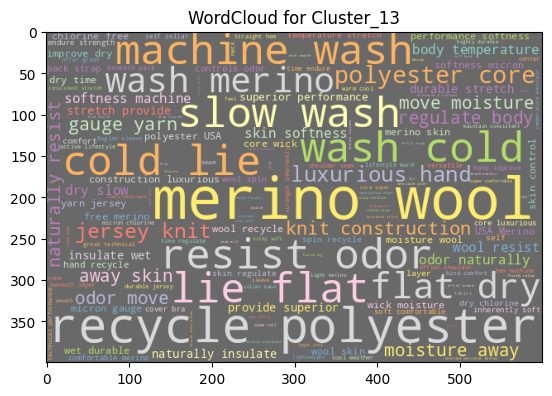

3 examples from Cluster_13 

Merino 2 crew - Be moved by the people and culture of a new place - but not in sticky, itchy clothes. Made from our most versatile merino layer for an active lifestyle in warm to cool weather, this lightweight crew features 73% merino wool spun around an all-recycled polyester (27%) core for a luxurious hand, an improved dry time and enduring strength. Inherently soft and comfortable, merino naturally resists odor, moves moisture away from the skin, regulates body temperature, and stretches. The wide cuff bands hold sleeves in place; side seams roll backward for a smooth fit; and arm seams are positioned to not interfere with pack straps. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Slow-washed merino wool resists odor naturally, insulates even when wet, is durable and stretches, provides superior performance and softness"</li> 

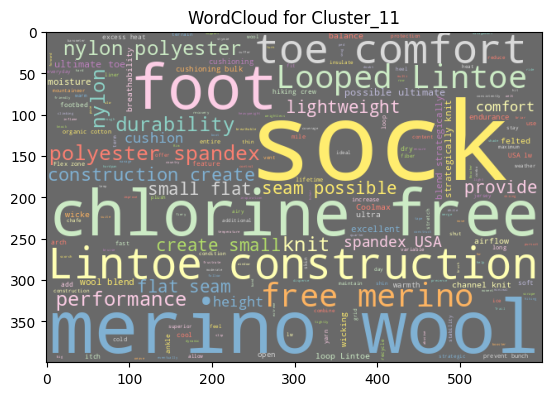

3 examples from Cluster_11 

Ultra lw endurance ped socks - Socks for fiery days when even the shade feels scorched. These are our thinnest, lightest weight socks with minimal ankle coverage for turning on the boosters. Their channel-knit construction maximizes cushion while minimizing weight, increases airflow and dissipates excess heat. Other features include a looped Lintoe construction for a smooth, inconspicuous toe seam and the low-profile fit is cut higher in back for extra Achilles protection. Made from 30% nylon/28% Coolmax/27% chlorine-free merino wool/12% polyester/3% spandex. Height is 3".<br><br><b>Details:</b><ul> <li>Ultra-lightweight wool blend strategically knit for excellent breathability and wicking</li> <li>"Full, channel-knit construction under the entire foot provides the most cushioning with the least bulk"</li> <li>Looped Lintoe construction creates the smallest and flattest seam possible for ultimate toe comfort</li> <li>Flex zones at toe for comfort and to pre

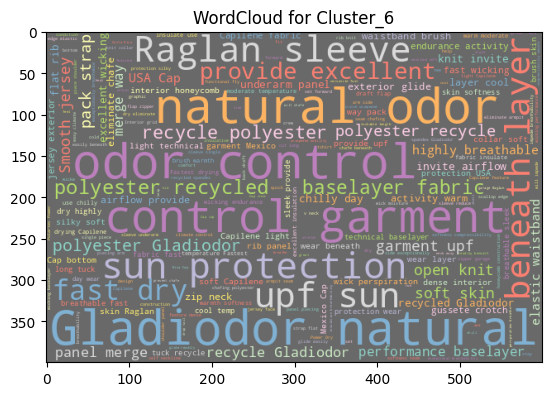

3 examples from Cluster_6 

Cap 2 t-shirt - Like a sweet breeze for long runs and hot days, Capilene 2 features an open knit that invites airflow to keep you cool and provides excellent wicking and exceptional breathability to keep you dry. Also insulative enough for chilly days when winter hasn't quite released its grip, it's the fastest-drying of our performance baselayer fabrics. With a feminine neck and elbow-length sleeves that stay put. Raglan-style sleeves and flat-ribbed underarm panels merge out of the way of straps to eliminate chafe. Made from 4-oz 100% polyester (54% recycled) with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>Fabric has an open knit that invites airflow and provides excellent wicking for endurance activities in warm to moderate temperatures</li> <li>"Fastest-drying of our Capilene fabrics, it insulates enough for use on chilly days and can be worn beneath other layers

In [72]:
for i in set(df['cluster']):
    words = ''
    for document in df[df['cluster'] == i]['cleaned_docs']:
        words += document + ' '
    wordcloud = WordCloud(width=600, height=400, background_color='#696969', colormap='Set3').generate(words)
    plt.imshow(wordcloud)
    plt.title("WordCloud for {}".format(i))
    plt.show()
    print("3 examples from", i, '\n')
    print("\n\n ".join(df[df['cluster'] == i]['description'].sample(3).tolist()), "\n\n")

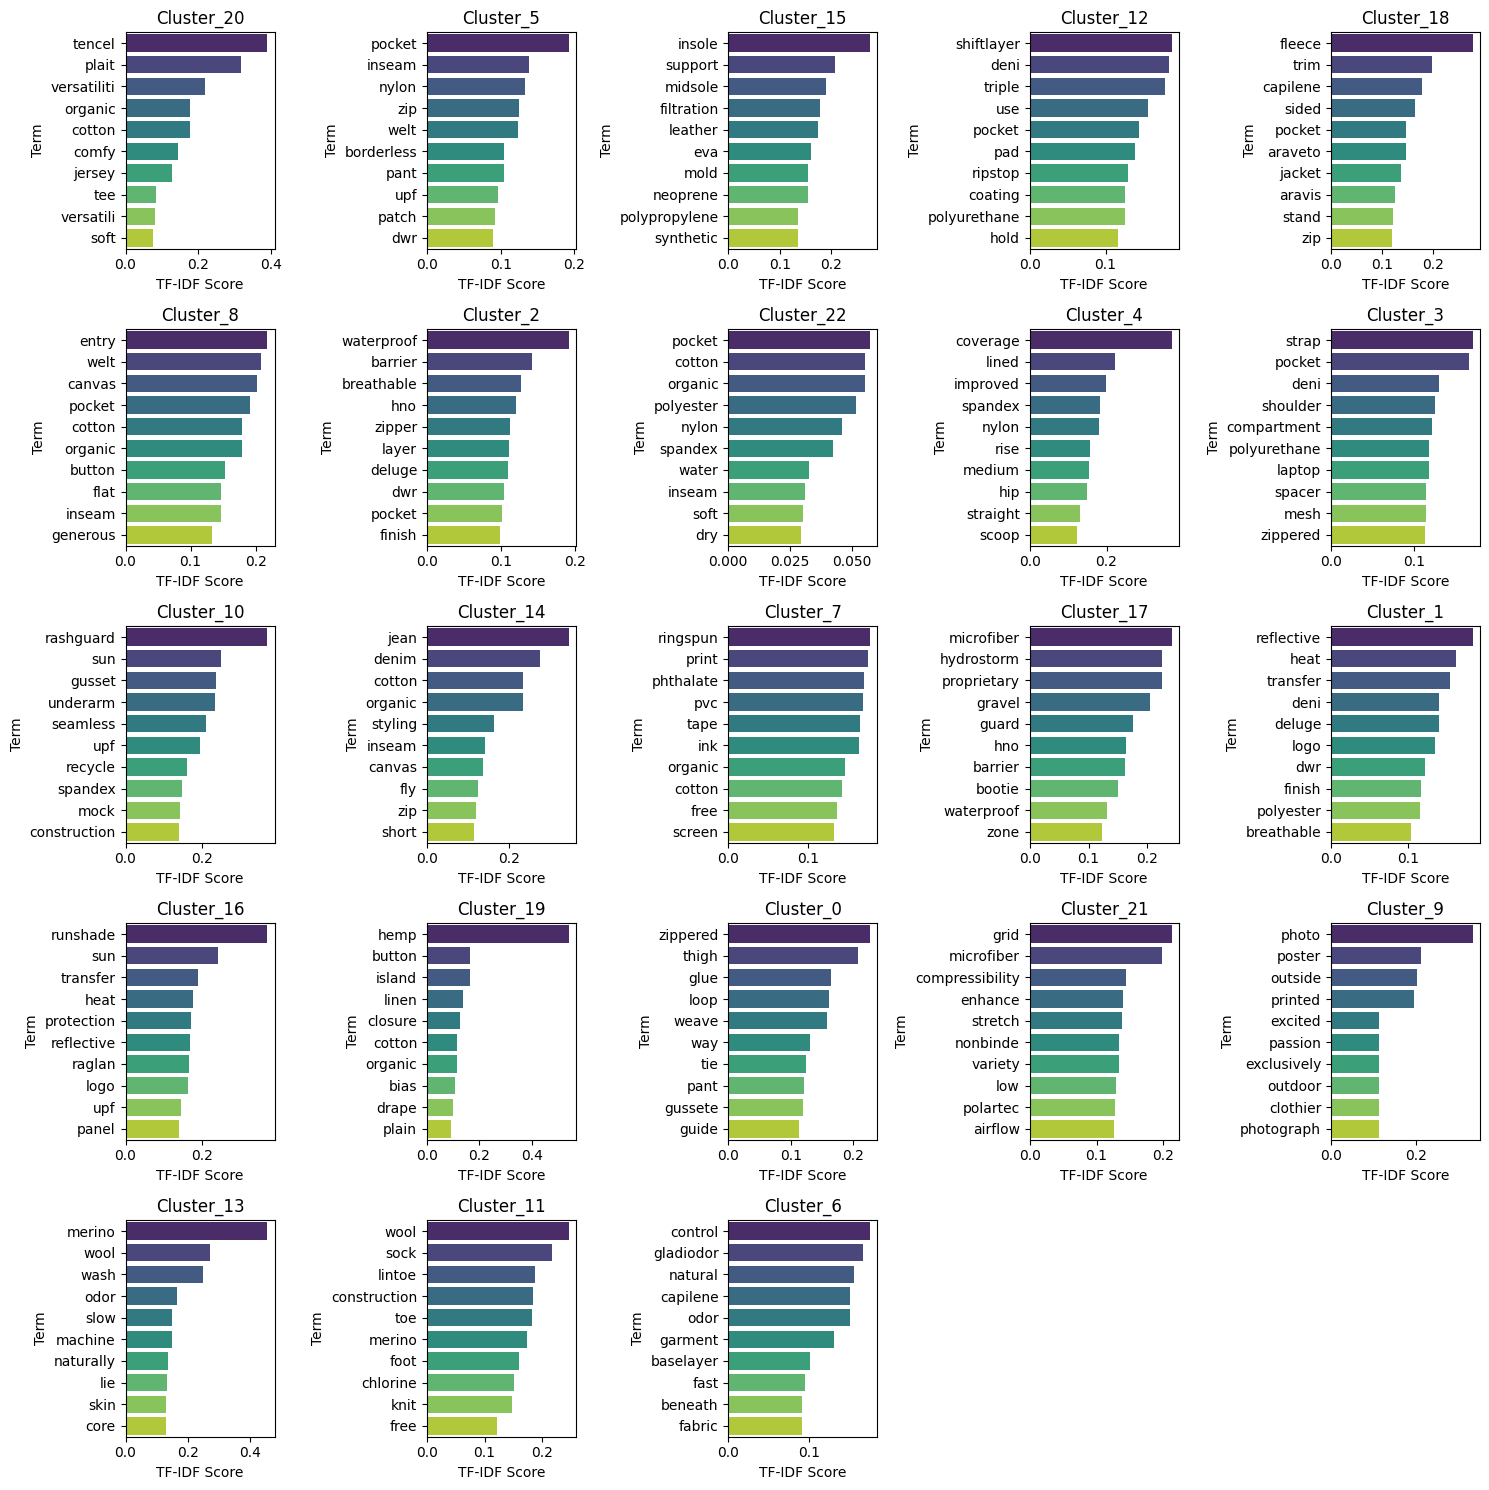

In [77]:
cluster_scores = {}
for i in set(df['cluster']):
    indices = df[df['cluster'] == i].index
    sum_scores = tfidf[tfidf.index.isin(indices)].mean()
    cluster_scores[i] = sum_scores.sort_values(ascending=False).head(10)

# Create a 5x2 grid layout for subplots (5 graphs in each row)
num_clusters = len(cluster_scores)
rows = (num_clusters + 4) // 5  # Calculate the number of rows needed
fig, axes = plt.subplots(rows, 5, figsize=(15, 3 * rows))

for idx, (cluster, scores) in enumerate(cluster_scores.items(), start=1):
    row = (idx - 1) // 5
    col = (idx - 1) % 5
    ax = axes[row, col]
    sns.barplot(x=scores.values, y=scores.index, palette='viridis', ax=ax)
    ax.set_title(f'{cluster}')
    ax.set_xlabel('TF-IDF Score')
    ax.set_ylabel('Term')

# Hide any unused subplots
for i in range(num_clusters, rows * 5):
    row = i // 5
    col = i % 5
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


## Alternative Approach: Hierarchical Density-Based Clustering( HDBSCAN )

In [80]:
hdb = hdbscan.HDBSCAN(min_cluster_size=5 ,metric='cosine', cluster_selection_epsilon = 0.6)
hdb.fit(X)

set(hdb.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18}

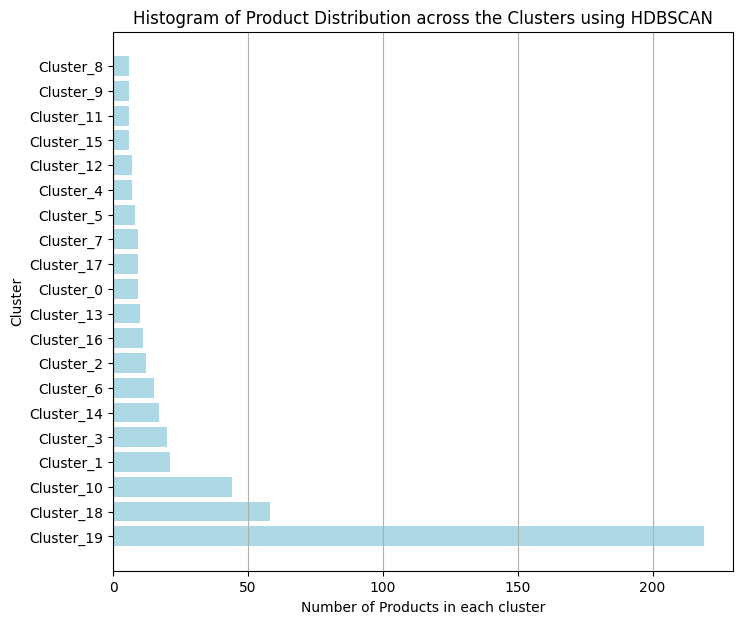

In [81]:
pred_to_label = {}
for label,prediction in enumerate(list(set(hdb.labels_))):
    pred_to_label[prediction] = "Cluster_"+ str(label)
pred_to_label

hdb_predictions = hdb.fit_predict(X).tolist()
df['hdb_cluster'] = [pred_to_label[x] for x in hdb_predictions]

plt.figure(figsize=(8, 7))
plt.barh(df["hdb_cluster"].unique(), df["hdb_cluster"].value_counts(), color= 'lightblue')
# Adding labels and title
plt.xlabel('Number of Products in each cluster')
plt.ylabel('Cluster')
plt.title('Histogram of Product Distribution across the Clusters using HDBSCAN')

plt.grid(axis='x')

plt.show()

In [83]:
for i in set(df['hdb_cluster']):
    print("3 examples from", i, '\n')
    print("\n\n ".join(df[df['hdb_cluster'] == i]['description'].sample(3).tolist()), "\n\n")


3 examples from Cluster_5 

Lw everyday socks - An essential part of the daily grind, these exceptionally soft, wearable socks have an inviting mix of 55% organic cotton/40% stretch nylon/5% spandex for moisture-wicking next-to-skin comfort. An open grid over the top of the foot and a looped Lintoe construction combine to create excellent airflow for breathability and kick-your-feet-up foot comfort. The jersey-knit cuff extends to mid-calf; height is 9.5".<br><br><b>Details:</b><ul> <li>Organic cotton and nylon blend is ideal for everyday use</li> <li>"Fabric content and strategic knit balance moisture wicking, cushioning, durability and comfort"</li> <li>An open grid over top of foot allows excellent airflow and breathability</li> <li>Looped Lintoe construction creates the smallest and flattest seam possible for ultimate toe comfort</li></ul><br><br><b>Fabric: </b>55% organic cotton/40% nylon/5% spandex<br><br><b>Weight: </b>(49 g 1.7 oz)<br><br>Made in USA.

 Lw endurance ankle socks

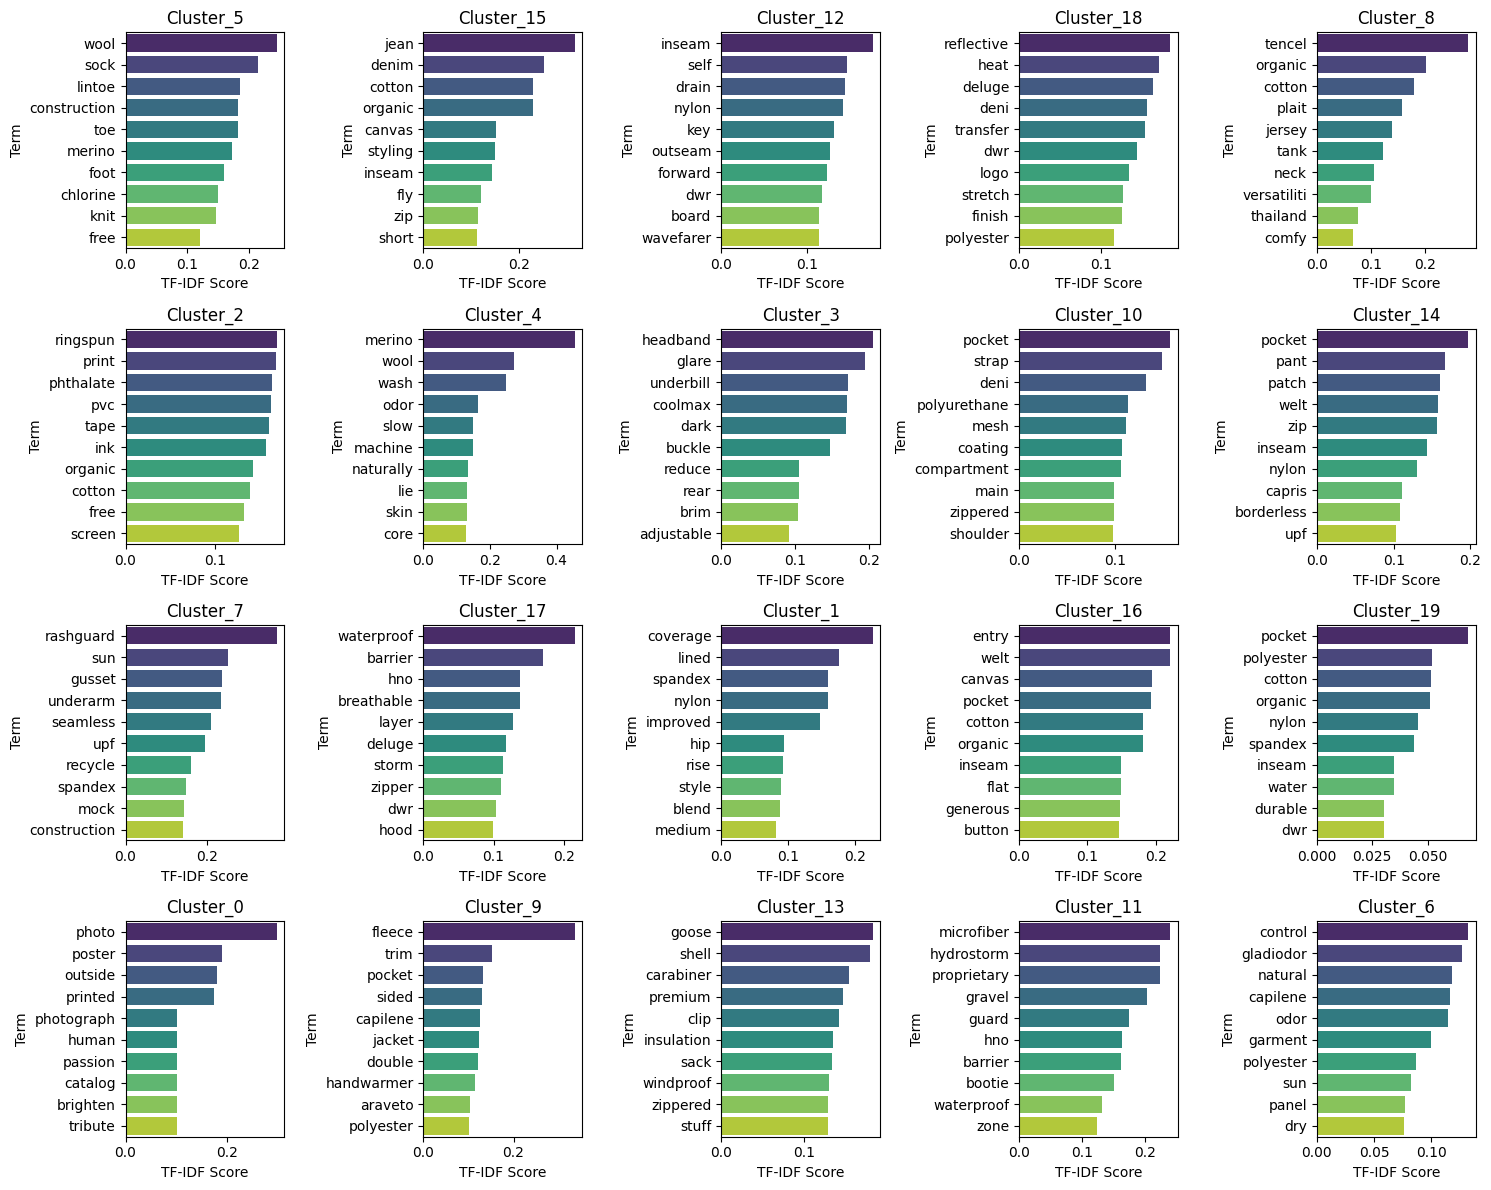

In [82]:
cluster_scores = {}
for i in set(df['hdb_cluster']):
    indices = df[df['hdb_cluster'] == i].index
    sum_scores = tfidf[tfidf.index.isin(indices)].mean()
    cluster_scores[i] = sum_scores.sort_values(ascending=False).head(10)

# Create a 5x2 grid layout for subplots (5 graphs in each row)
num_clusters = len(cluster_scores)
rows = (num_clusters + 4) // 5  # Calculate the number of rows needed
fig, axes = plt.subplots(rows, 5, figsize=(15, 3 * rows))

for idx, (cluster, scores) in enumerate(cluster_scores.items(), start=1):
    row = (idx - 1) // 5
    col = (idx - 1) % 5
    ax = axes[row, col]
    sns.barplot(x=scores.values, y=scores.index, palette='viridis', ax=ax)
    ax.set_title(f'{cluster}')
    ax.set_xlabel('TF-IDF Score')
    ax.set_ylabel('Term')

# Hide any unused subplots
for i in range(num_clusters, rows * 5):
    row = i // 5
    col = i % 5
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


## PART 2: Recommender System

### First Approach: Using Clusters

In [84]:
df.head()

id                                        description  \
0   1  Active classic boxers - There's a reason why o...   
1   2  Active sport boxer briefs - Skinning up Glory ...   
2   3  Active sport briefs - These superbreathable no...   
3   4  Alpine guide pants - Skin in, climb ice, switc...   
4   5  Alpine wind jkt - On high ridges, steep ice an...   

                                  description_nohtml  \
0  Active classic boxers - There's a reason why o...   
1  Active sport boxer briefs - Skinning up Glory ...   
2  Active sport briefs - These superbreathable no...   
3  Alpine guide pants - Skin in, climb ice, switc...   
4  Alpine wind jkt - On high ridges, steep ice an...   

                                description_nohtml_2  \
0  Active classic boxers - There's a reason why o...   
1  Active sport boxer briefs - Skinning up Glory ...   
2  Active sport briefs - These superbreathable no...   
3  Alpine guide pants - Skin in, climb ice, switc...   
4  Alpine wind jkt - On high ridges, steep ice an...   

                                       description_2  \
0  Active classic boxers - There's a reason why o...   
1  Active sport boxer briefs - Skinning up Glory ...   
2  Active sport briefs - These superbreathable no...   
3  Alpine guide pants - Skin in, climb ice, switc...   
4  Alpine wind jacket - On high ridges, steep ice...   

                                        cleaned_docs     cluster hdb_cluster  
0  active classic boxer reason boxer cult favorit...  Cluster_22  Cluster_19  
1  active sport boxer brief skin glory require mo...  Cluster_22  Cluster_19  
2  active sport brief superbreathable fly brief m...  Cluster_22  Cluster_19  
3  alpine guide pant skin climb ice switch rock t...   Cluster_0  Cluster_19  
4  alpine wind jacket high ridge steep ice alpine...   Cluster_1  Cluster_18

In [87]:
id2index = pd.Series(df.index, index = df["id"])
id2index

id
1        0
2        1
3        2
4        3
5        4
      ... 
496    495
497    496
498    497
499    498
500    499
Length: 500, dtype: int64

In [102]:
def find_similar_items():
    item_id = int(input("Enter the item ID: "))
    idx = id2index[item_id]
    print("Product Description of the item you chose: \n", df['description'][idx])
    cluster = df['hdb_cluster'][idx]

    #filter the items belonging to that same cluster and get 5 random items from that cluster:
    recommend_id = df[df['hdb_cluster']==cluster]["id"].sample(n=5)


    print("\nSimilar Products \n")

    for id in recommend_id:
        print("Product ID:", id)
        recommend_idx = id2index[id]
        print("Product description:", df['description'][recommend_idx],"\n")

In [103]:
find_similar_items()

Enter the item ID: 350
Product Description of the item you chose: 
 Shop pants - long - More at home under the truck than inside it, our Shop Pants are made from garment-washed 10-oz 100% organic cotton canvas that's tool-resistant yet breaks in easily. They have a shaped waist, jeans-style pocketing, steel rivets, double-fabric knees and reinforced "mud flaps" above the cuffs. Inseams (size 32): regular is 32";  short is 30" and long 34". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Made from 10-oz year-round weight organic cotton canvas for a tough, yet skin-friendly feel"</li> <li>Waistband slightly lower in front for fit and mobility</li> <li>Zip fly with button closure</li> <li>5-pocket jeans styling</li> <li>Patch pockets on back</li> <li>Double-fabric knees; straight legs</li> <li>"Inseam length is 34"""</li></ul><br><br><b>Fabric: </b>10-oz 100% organic cotton canvas. Recyclable through the Common Threads Recycling Program<br><br><b>W

In [105]:
find_similar_items()

Enter the item ID: 90
Product Description of the item you chose: 
 Merino 2 t-shirt - Stay calm and collected amid the frenzy of Namche Bazaar in this versatile layer. Designed for an active lifestyle in warm to cool weather, Merino 2 is made from 73% merino wool wrapped around an all-recycled polyester (27%) core for a luxurious hand, an improved dry time and enduring strength. Inherently soft and comfortable, merino naturally resists odor, moves moisture away from the skin, regulates body temperature, and stretches. Features include raglan sleeves and offset side seams that won't chafe beneath pack straps, a self-fabric collar for soft comfort and overlocked seams for a clean aesthetic. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Slow-washed merino wool resists odor naturally, insulates even when wet, is durable and stretches, provides superior performan

### Second Approach: Using Cosine Similarity Directly

As an alternative method to random selection from clusters, what we can do is to use cosine_similarity scores (the inverse of the cosine distance) to directly access to the descriptions that are most similar to the description of the product we choose.

In this method, we won't need to use product clusters.

In [ ]:
query = X[2]
scores = cosine_similarity(query, X).flatten()
recommend_idx = (-scores).argsort()[1:6]
recommend_idx

array([  1, 299, 494, 155, 298])

In [106]:
def find_similar_items():
    item_id = int(input("Enter the item ID: "))
    idx = id2index[item_id]
    print("Product Description of the item you chose: \n", df['description'][idx])

    #we will need the tfidf matrix of documents we created earlier (matrix X)
    query = X[idx]

    #now we will generate a cosine_similarity matrix that shows
    # the cosine similarity scores of each document to our selected document

    scores = cosine_similarity(query, X).flatten() #i flattened it so that I could sort by scores
    recommend_idx = (-scores).argsort()[1:6] #this will give index numbers of top 5 similar items
     # attention : index 0 is gonna be the chosen product itself, this is why we slice [1:6] instead of [0:5]
    print("\nSimilar Products \n")

    for idx in recommend_idx:
        print("Product ID:", df['id'][idx])
        print("Product description:", df['description'][idx],"\n")

In [107]:
find_similar_items()

Enter the item ID: 200
Product Description of the item you chose: 
 Merino 1 graphic t-shirt - Feels as good as a laugh. Our lightest merino layer, this silky-soft yet highly durable jersey-knit is made with 63% merino wool spun around a an all-recycled polyester (37%) core. Super-comfortable on its own in warm temperatures or beneath layers in cooler ones, it offers great technical performance: naturally resisting odor, moving moisture away from the skin and improving dry times, regulating body temperature, and maintaining a consistent stretch. The neck - with a smooth, self-fabric binding - invites ventilation but still covers a bra. We slow-wash our merino for next-to-skin softness. Machine-wash cold; lay flat to dry. Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Slow-washed merino wool resists odor naturally, insulates even when wet, is durable, stretches and provides superior performance and softness; 16.5 micron-gauge yarn and jersey-kni

In [109]:
find_similar_items()

Enter the item ID: 350
Product Description of the item you chose: 
 Shop pants - long - More at home under the truck than inside it, our Shop Pants are made from garment-washed 10-oz 100% organic cotton canvas that's tool-resistant yet breaks in easily. They have a shaped waist, jeans-style pocketing, steel rivets, double-fabric knees and reinforced "mud flaps" above the cuffs. Inseams (size 32): regular is 32";  short is 30" and long 34". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Made from 10-oz year-round weight organic cotton canvas for a tough, yet skin-friendly feel"</li> <li>Waistband slightly lower in front for fit and mobility</li> <li>Zip fly with button closure</li> <li>5-pocket jeans styling</li> <li>Patch pockets on back</li> <li>Double-fabric knees; straight legs</li> <li>"Inseam length is 34"""</li></ul><br><br><b>Fabric: </b>10-oz 100% organic cotton canvas. Recyclable through the Common Threads Recycling Program<br><br><b>W

## PART 3: Topic Modeling

In [113]:
n_comp = 20
svd_model = TruncatedSVD(n_components=n_comp, n_iter=100, random_state=42)
lsa = svd_model.fit_transform(X)

In [115]:
topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_"+ str(i+1) for i in range(n_comp)])
topic_encoded_df["documents"] = df['cleaned_docs']
topic_encoded_df.head()

topic_1   topic_2   topic_3   topic_4   topic_5   topic_6   topic_7  \
0  0.219213 -0.054070  0.185457  0.095609 -0.112144  0.008690 -0.085829   
1  0.259238 -0.046901  0.095304  0.112655 -0.027340  0.152216 -0.008365   
2  0.243889 -0.077448  0.106307  0.033260 -0.029022  0.134865  0.088005   
3  0.396821 -0.220975 -0.128159 -0.152612  0.054441  0.037520 -0.032051   
4  0.419695 -0.231941 -0.023083 -0.246702 -0.019133 -0.029658  0.044023   

    topic_8   topic_9  topic_10  ...  topic_12  topic_13  topic_14  topic_15  \
0 -0.040414 -0.134803 -0.001717  ...  0.033706  0.070907 -0.016426  0.020976   
1 -0.036827 -0.129735 -0.038491  ... -0.020446  0.129439 -0.029171 -0.047820   
2  0.046417 -0.118063  0.040458  ... -0.085111  0.152275 -0.052938 -0.062780   
3 -0.056905 -0.045665 -0.125378  ...  0.172103  0.121049  0.126294  0.029563   
4  0.067978  0.014955 -0.193223  ...  0.265200  0.164388 -0.202116  0.003975   

   topic_16  topic_17  topic_18  topic_19  topic_20  \
0  0.015488 -0.004684 -0.018056  0.039981  0.026367   
1  0.104482  0.107198 -0.039546  0.139842  0.035196   
2  0.073578  0.063925 -0.079684  0.128871  0.067714   
3  0.068718  0.020690 -0.204174 -0.016454 -0.033087   
4 -0.056224 -0.039883  0.064406 -0.007643  0.071596   

                                           documents  
0  active classic boxer reason boxer cult favorit...  
1  active sport boxer brief skin glory require mo...  
2  active sport brief superbreathable fly brief m...  
3  alpine guide pant skin climb ice switch rock t...  
4  alpine wind jacket high ridge steep ice alpine...  

[5 rows x 21 columns]

In [118]:
def plot_top_words(model, feature_names, n_top_words=10):
    fig, axes = plt.subplots(4, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            ax.barh(top_features, weights, height=0.7, color = 'lightblue')
            ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
            ax.invert_yaxis()
            ax.tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
            ax.spines[i].set_visible(False)
            fig.suptitle('LSA', fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()



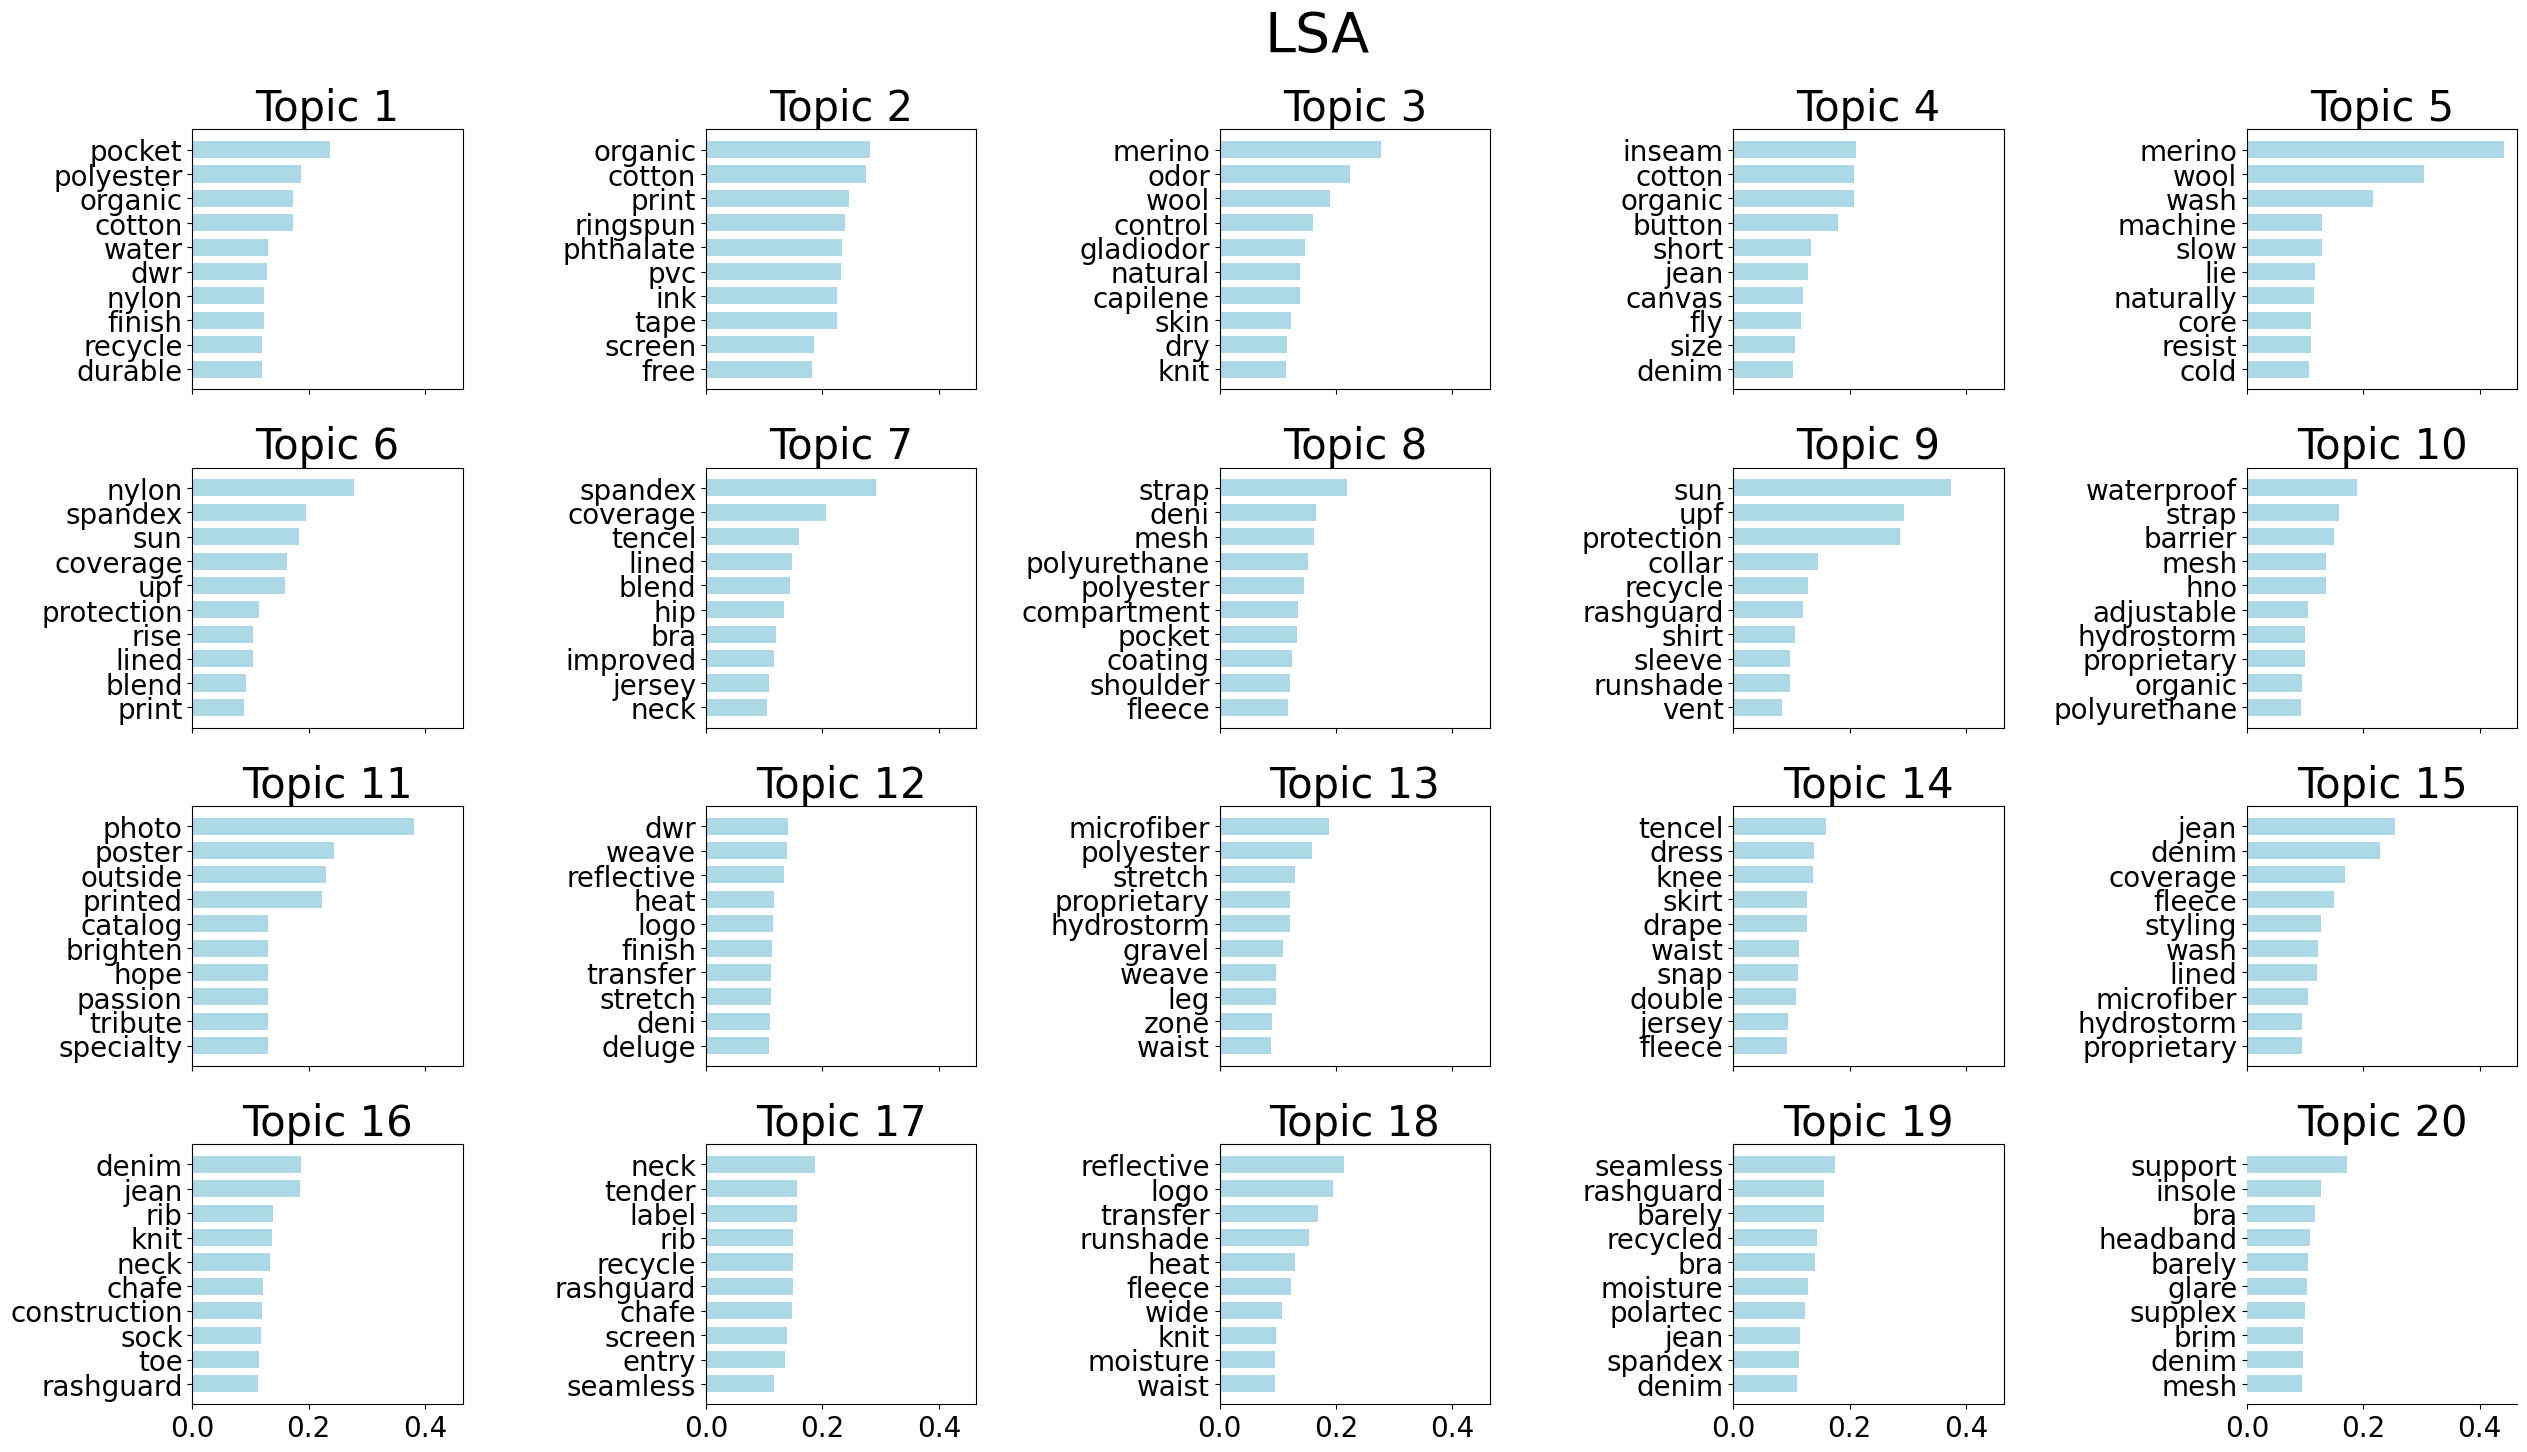

In [119]:
feature_names = vectorizer.get_feature_names_out() #it's the reverse of word2idx ; an idx2word mapping
#it's stored in count vectorizer object
plot_top_words(svd_model, feature_names);